# Setup

## Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DataScience/machine_learning/competitions/kaggle/Titanic
sys.path.append('/content/drive/MyDrive/DataScience/machine_learning')

## Local

In [1]:
import os
import sys

# Define Project root folder 
PROJECT_ROOT_DIR = "."
folder_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(folder_path, exist_ok=True)

## Normal

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Libraries

In [3]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Data scaling
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error

In [4]:
# Libraries for custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Data Loading

In [5]:
dataset = pd.read_csv(os.path.join(PROJECT_ROOT_DIR, 'datasets', 'train.csv'))
test = pd.read_csv(os.path.join(PROJECT_ROOT_DIR, 'datasets', 'test.csv'))

dataset = dataset.set_index('PassengerId')
test = test.set_index('PassengerId')

In [6]:
dataset.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
dataset.shape

(891, 11)

# Train-Val Split

## Quick Look At Data

Get a glimpse at the data provided and determine how to divide data into train and test

In [8]:
import seaborn as sns

In [9]:
dataset.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
# Percentage of missing values

# check if every cell isnull or not and sum them up accross the column
missing_values = dataset.isnull().sum()
missing_values[missing_values>0]/len(dataset)*100

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

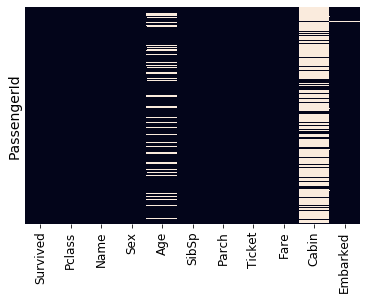

In [11]:
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False)

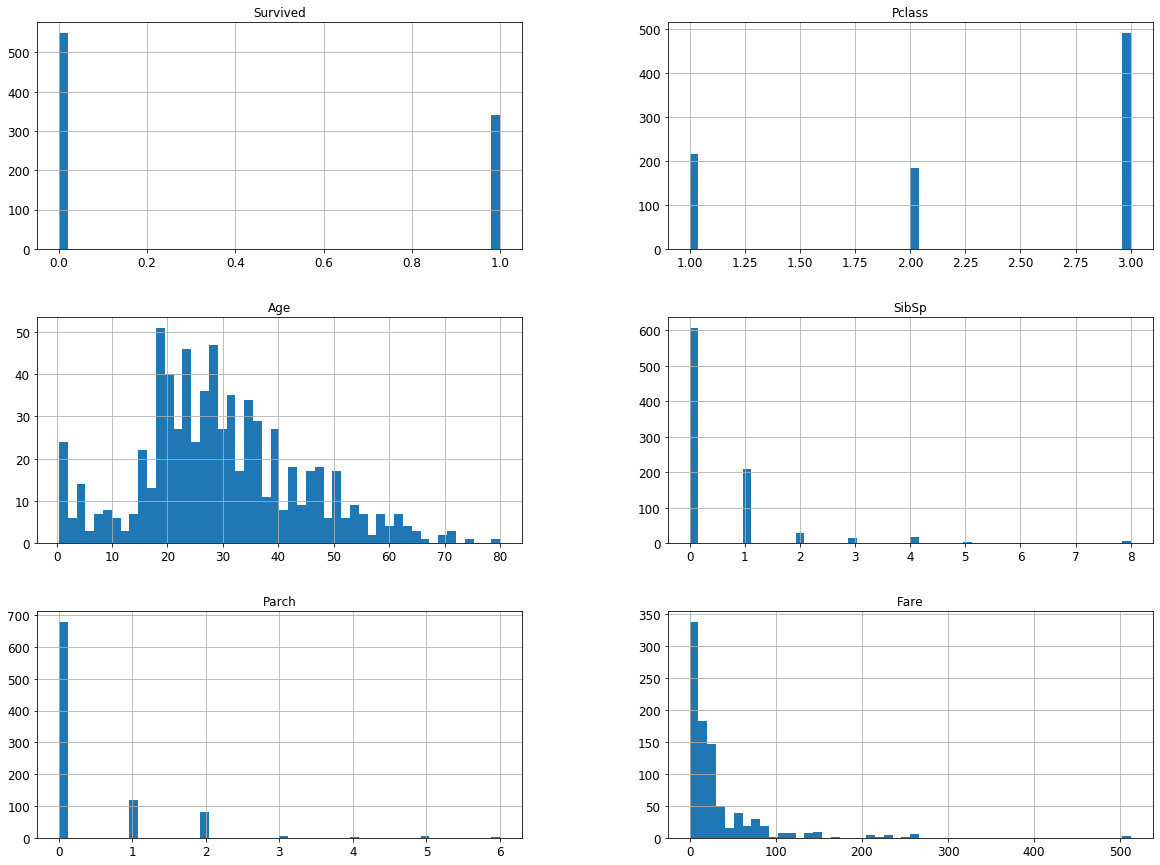

In [13]:
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

## Data Split

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(dataset, test_size=0.2)

In [ ]:
y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)

X_val = val.drop(['Survived'], axis=1)
y_val = val['Survived']

# Data Type

In [ ]:
label_col = "Survived"
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in train.columns if train[col].dtype in ['object']]

print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

In [ ]:
card = [X_train[col].nunique() for col in cat_cols]
for a, b in zip(cat_cols, card):
    print(a, b)

print()
low_card_cols = [col for col in cat_cols if X_train[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if X_train[col].nunique() > 10]
print('low_card_cols:', low_card_cols)
print('high_card_cols:', high_card_cols)

# Data Cleaning

## Filling NaN Values

In [ ]:
imputer = ColumnTransformer([
    ('imputer_num', SimpleImputer(strategy='median'), num_cols),
    ('imputer_cat', SimpleImputer(strategy='most_frequent'), cat_cols)
])

In [ ]:
clean_pipe = Pipeline([
    ('imputer', imputer)
])

In [ ]:
train.info()

In [ ]:
train_clean = clean_pipe.fit_transform(train)
train_clean

In [ ]:
train_clean = pd.DataFrame(train_clean, index=train.index)
train_clean.columns = num_cols + cat_cols
train_clean.head()

In [ ]:
# After imputing, all dtype will change to 'object'
# So need to reassign float64 type to num_cols
train_clean_ = train_clean[num_cols].astype('float64')
train_clean = train_clean_.join(train_clean[cat_cols])

In [ ]:
train_clean.info()

## Remove Outliers

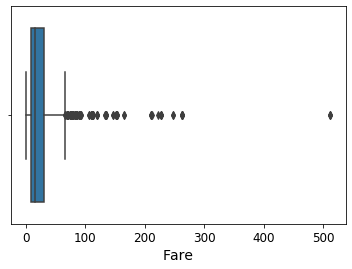

In [59]:
# black vertical line represents quartiles +- (1.5 * interquartile_range)
# black points are outliers
sns.boxplot(dataset.Fare, data=dataset)

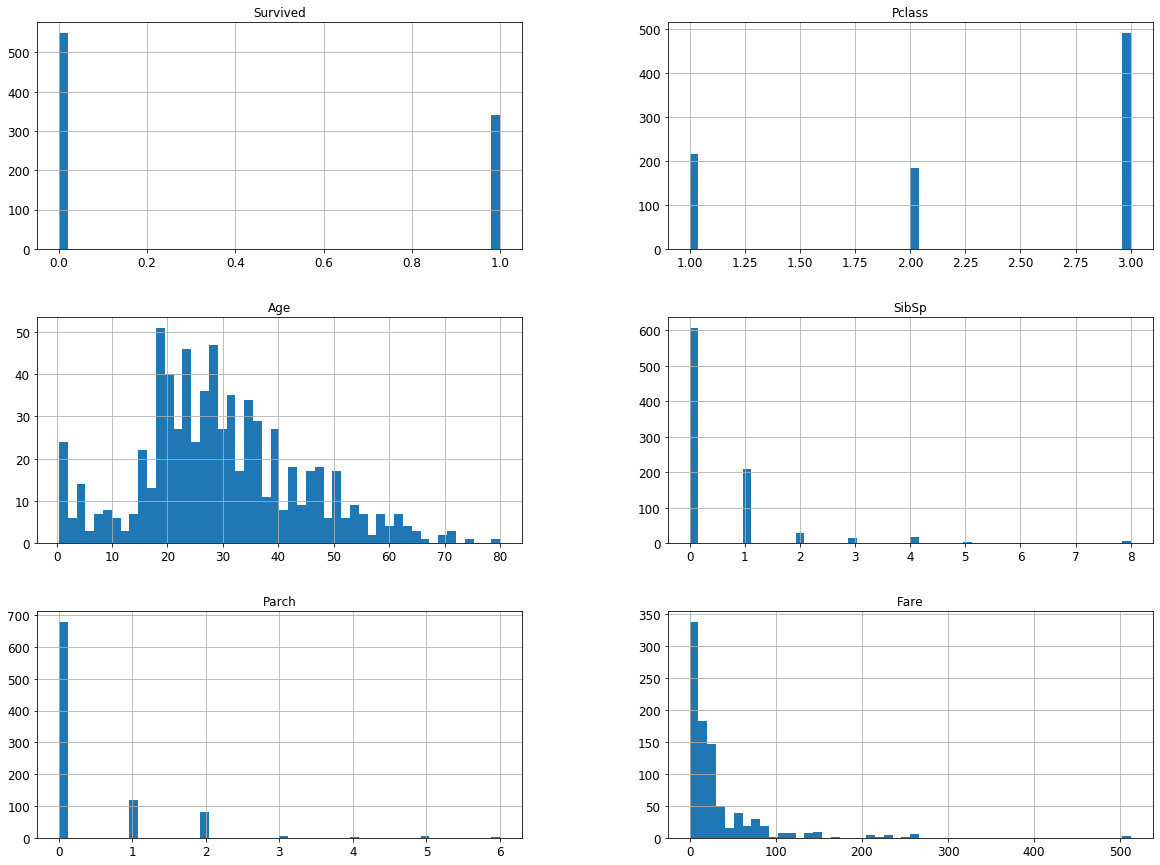

In [13]:
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

In [16]:
# Fare distribution has been right shifted, indicating the presence of outliers
print('skewness value of Age: ', dataset['Age'].skew())
print('skewness value of Fare: ',dataset['Fare'].skew())

skewness value of Age:  0.38910778230082704
skewness value of Fare:  4.787316519674893


In [17]:
dataset.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [55]:
dataset_clean = dataset.copy()

In [60]:
q1 = dataset.Fare.quantile(0.25)
q3 = dataset.Fare.quantile(0.75)
iqr = q3 - q1

whisker_width = 1.5
lower_whisker = q1 - whisker_width * iqr
upper_whisker = q3 + whisker_width * iqr

fare_outliers = dataset[(dataset.Fare < q1 - lower_whisker) | (dataset.Fare > upper_whisker)]
fare_outliers.Fare.count()

807

In [57]:
# Flooring and capping outliers to boundary values
dataset_clean.Fare = np.where(
    dataset.Fare > upper_whisker,
    upper_whisker,
    np.where(
        dataset.Fare < lower_whisker,
        lower_whisker,
        dataset.Fare
    )
)

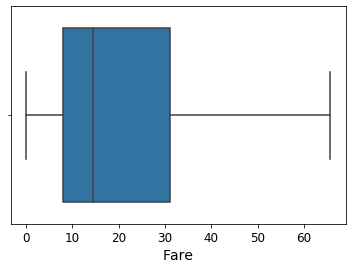

In [58]:
sns.boxplot(dataset_clean.Fare, data=dataset_clean)

In [29]:
fare_mean = dataset.Fare.mean()
fare_std = dataset.Fare.std()
low = fare_mean - 3 * fare_std
high = fare_mean + 3 * fare_std
fare_outliers = dataset[(dataset.Fare < low) | (dataset.Fare > high)]
fare_outliers.Fare.count()

20

# Data Analysis

## Correaltions

In [ ]:
train_clean.hist(bins=50, figsize=(20,15), legend=True)

In [ ]:
corr = train_clean.corr()

corr['Survived'].sort_values(ascending=False)

In [ ]:
train_clean.Fare.max()

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Fare", "Pclass", "Parch"]
scatter_matrix(train_clean[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [ ]:
import seaborn as sns
sns.pairplot(train_clean, palette='Dark2')

## Age Bucket
Divide ages into several intervals, that each age interval will have different survival rate

In [ ]:
train_clean['AgeBucket'] = train_clean['Age'] // 15 * 15

## Relatives On Board

In [ ]:
train_clean['RelativesOnboard'] = train_clean.SibSp + train_clean.Parch
train_clean[['RelativesOnboard', 'Survived']].groupby(['RelativesOnboard']).mean()

## Name Title

In [ ]:
train_clean.Name.head(20)

In [ ]:
def extract(name, titles):
    for t in titles:
        if t in name:
            return t
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']

train_clean['Title'] = train_clean['Name'].map(lambda name: extract(name, title_list))


In [ ]:
print(train_clean.Title.nunique())
train_clean.Title.value_counts()

In [ ]:
train_clean[train_clean.Title.isna()]

In [ ]:
train_clean.shape

## Cabin to Deck 

In [ ]:
train_clean.Cabin.head(10)

In [ ]:
#Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train_clean['Deck'] = train_clean['Cabin'].map(lambda x: extract(x, cabin_list))

In [ ]:
train_clean.Deck.value_counts()

## Surname

In [84]:
train_clean.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [85]:
train_clean['Surname'] = train_clean['Name'].map(lambda x: x.split(',', 1)[0])

In [86]:
train_clean.Surname

0         Braund
1        Cumings
2      Heikkinen
3       Futrelle
4          Allen
         ...    
886     Montvila
887       Graham
888     Johnston
889         Behr
890       Dooley
Name: Surname, Length: 891, dtype: object

In [95]:
# list of unique values
surname_unique = train_clean.Surname.unique()
len(surname_unique)

667

In [90]:
# from the same family...
surname_value_counts = train_clean.Surname.value_counts()
surname_value_counts

Andersson        9
Sage             7
Johnson          6
Panula           6
Skoog            6
                ..
Jenkin           1
Sivola           1
Reynaldo         1
Slocovski        1
Lemberopolous    1
Name: Surname, Length: 667, dtype: int64

In [91]:
num_passenger = len(train_clean)
surname_one_lived = [0]*num_passenger
num_sur_died = [0]*len(surname_unique)

surname_dic = dict(zip(surname_unique, num_sur_died))
# print(surname_dic)

for index, row in train_clean.iterrows():
    if row['Survived'] == 0:
        surname_dic[row['Surname']] += 1

print(surname_dic)


{'Braund': 2, 'Cumings': 0, 'Heikkinen': 0, 'Futrelle': 1, 'Allen': 1, 'Moran': 2, 'McCarthy': 1, 'Palsson': 4, 'Johnson': 3, 'Nasser': 1, 'Sandstrom': 0, 'Bonnell': 0, 'Saundercock': 1, 'Andersson': 7, 'Vestrom': 1, 'Hewlett': 0, 'Rice': 5, 'Williams': 3, 'Vander Planke': 3, 'Masselmani': 0, 'Fynney': 1, 'Beesley': 0, 'McGowan': 0, 'Sloper': 0, 'Asplund': 1, 'Emir': 1, 'Fortune': 2, "O'Dwyer": 0, 'Todoroff': 1, 'Uruchurtu': 1, 'Spencer': 0, 'Glynn': 0, 'Wheadon': 1, 'Meyer': 2, 'Holverson': 1, 'Mamee': 0, 'Cann': 1, 'Nicola-Yarred': 0, 'Ahlin': 1, 'Turpin': 2, 'Kraeff': 1, 'Laroche': 1, 'Devaney': 0, 'Rogers': 1, 'Lennon': 1, "O'Driscoll": 0, 'Samaan': 1, 'Arnold-Franchi': 2, 'Panula': 6, 'Nosworthy': 1, 'Harper': 1, 'Faunthorpe': 0, 'Ostby': 1, 'Woolner': 0, 'Rugg': 0, 'Novel': 1, 'West': 1, 'Goodwin': 6, 'Sirayanian': 1, 'Icard': 0, 'Harris': 2, 'Skoog': 6, 'Stewart': 1, 'Moubarek': 0, 'Nye': 0, 'Crease': 1, 'Kink': 1, 'Jenkin': 1, 'Hood': 1, 'Chronopoulos': 1, 'Bing': 0, 'Moen': 1,

In [99]:
t = list(surname_dic.values())
surname_all_died = [surname_unique[i] for i in range(len(t)) if t[i] == surname_value_counts[i]]
len(surname_all_died)

319

In [ ]:
## Seems not working
# lalala = train_clean.copy()
# lalala['SurnameAllDied'] = 1 if lalala['Surname'] in surname_all_died else 0
# lalala['SurnameAllDied'] = np.where(lalala['Surname'] in surname_all_died, 1, 0)
# lalala['SurnameAllDied']
# df['color'] = np.where(df['Set']=='Z', 'green', 'red')

i = 0
train_clean['SurnameAllDied'] = 0
for row in train_clean['Surname']:
    if row in surname_all_died:
        train_clean['SurnameAllDied'][i] = 1
    i += 1

# train_clean.SurnameAllDied[:10]

In [ ]:
corr = train_clean.corr()
corr['Survived'].sort_values(ascending=False)

# It shows that SurnameAllDied column has a really strong correlation with label

In [ ]:
surname_dic = None
surname_all_died = None
surname_count = None

def create_surname(df):
    df['Surname'] = df['Name'].map(lambda x: x.split(',', 1)[0])
    return df

def create_surname_all_died(df):
    global surname_dic, surname_all_died, surname_count

    # Create Surname Columns
    # df['Surname'] = df['Name'].map(lambda x: x.split(',', 1)[0])
    df = create_surname(df)
    surname_unique = df.Surname.unique()

    # num_passenger = len(df)
    # surname_one_lived = [0]*num_passenger
    l = [0]*len(surname_unique)

    surname_dic = dict(zip(surname_unique, l))

    surname_count = dict(zip(surname_unique, l))
    for index, row in df.iterrows():
        surname_count[row["Surname"]] += 1
        if row['Survived'] == 0:
            surname_dic[row['Surname']] += 1
    print(surname_count)
    
    t = list(surname_dic.values())
    surname_all_died = [surname_unique[i] for i in range(len(t)) if t[i] > 2]
    # print(surname_all_died)

    i = 0
    df['SurnameAllDied'] = 0
    for row in df['Surname']:
        if row in surname_all_died:
            df['SurnameAllDied'][i] = 1
        i += 1

    return df


In [ ]:
def create_survived(df):
    global surname_dic, surname_all_died, surname_count
    df = create_surname(df)     # Create df['Surname']
    # df['Survived'] = 0
    df['SurnameAllDied'] = 0
    for s in df.Surname:
        if s not in surname_count or surname_count[s] == 1:
            df['SurnameAllDied'] = 0
        elif surname_dic[s] >= 2:
            df['SurnameAllDied'] = 1

    print(df[:10])
    return df

In [100]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    float64
 1   Pclass            891 non-null    float64
 2   Age               891 non-null    float64
 3   SibSp             891 non-null    float64
 4   Parch             891 non-null    float64
 5   Fare              891 non-null    float64
 6   Name              891 non-null    object 
 7   Sex               891 non-null    object 
 8   Ticket            891 non-null    object 
 9   Cabin             891 non-null    object 
 10  Embarked          891 non-null    object 
 11  AgeBucket         891 non-null    float64
 12  RelativesOnboard  891 non-null    float64
 13  Title             891 non-null    object 
 14  Deck              891 non-null    object 
 15  Surname           891 non-null    object 
dtypes: float64(8), object(8)
memory usage: 111.5

In [ ]:
'''
Before:
Survived    1.000000
Fare        0.246641
Parch       0.078311
SibSp      -0.047602
Age        -0.048588
Pclass     -0.321750

After:
Survived            1.000000   # positive
Fare                0.246641
Parch               0.078311
RelativesOnboard    0.003565   # not useful
AgeBucket          -0.012755   # worse than Age
SibSp              -0.047602
Age                -0.048588
Pclass             -0.321750   # negative
'''
corr = train_clean.corr()

corr['Survived'].sort_values(ascending=False)

# Piplelines

## Columns Identifying

In [ ]:
train_clean.dtypes

In [ ]:
num_cols = [col for col in train_clean.columns if train_clean[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in train_clean.columns if train_clean[col].dtype in ['object']]

print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

In [ ]:
card = [train_clean[col].nunique() for col in cat_cols]
for a, b in zip(cat_cols, card):
    print(a, b)

low_card_cols = [col for col in cat_cols if train_clean[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if train_clean[col].nunique() > 10]
print('low_card_cols:', low_card_cols)
print('high_card_cols:', high_card_cols)

## High Cardinality Column Trans Class

In [ ]:
# High Cardinality Transformer: perform one-hot transformer for high-cardinality
# columns while avoiding generating too much dummpy features. It will only one-hot
# the classes with high proportion. A threshold can be set.

from collections import Counter

def cumulatively_categorise(column,threshold=0.9,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    #Return only the transformed column if return_categories=False
    else:
        return new_column

In [ ]:
class HighCardAggregation(BaseEstimator, TransformerMixin):
    def __init__(self, cols, transform_type='cumulatively_categorise'):
        self.cols = cols
        
        self.transform_type = transform_type
        if self.transform_type == 'cumulatively_categorise':
            self.transform_algo = self.cumulatively_categorise

    def fit(self, X, y = None):
        return self

    def cumulatively_categorise(self, column,threshold=0.9,return_categories_list=True):
        #Find the threshold value using the percentage and number of instances in the column
        threshold_value=int(threshold*len(column))
        #Initialise an empty list for our new minimised categories
        categories_list=[]
        #Initialise a variable to calculate the sum of frequencies
        s=0
        #Create a counter dictionary of the form unique_value: frequency
        counts=Counter(column)

        #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
        for i,j in counts.most_common():
            #Add the frequency to the global sum
            s+=dict(counts)[i]
            #Append the category name to the list
            categories_list.append(i)
            #Check if the global sum has reached the threshold value, if so break the loop
            if s>=threshold_value:
                break
        #Append the category Other to the list
        categories_list.append('Other')

        #Replace all instances not in our new categories by Other  
        new_column=column.apply(lambda x: x if x in categories_list else 'Other')

        #Return transformed column and unique values if return_categories=True
        if(return_categories_list):
            return new_column,categories_list
        #Return only the transformed column if return_categories=False
        else:
            return new_column
    
    def transform(self, X, y = None):
        X_df = pd.DataFrame(X, columns=self.cols)
        X_ = X_df.to_numpy()

        for col in self.cols:
            # transformed_columns is a pandas dataframe
            transformed_column, _ = self.transform_algo(column=X_df[col], threshold=0.9)            
            # concat transformed_column to X
            X_ = np.c_[X_, transformed_column.to_numpy()]
        
        # numpy array
        # delete original untransformed columns, only keep transformed columns
        X_ = np.delete(X_, [i for i in range(len(self.cols))], 1)
        return X_

## AddDelFeature Class

In [ ]:
class AddDelFeatureBase(BaseEstimator, TransformerMixin):
    def __init__(self, all_cols, num_cols, cat_cols):
        self.all_cols = all_cols
        self.num_cols = num_cols
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        return self
    
    def drop(self, X_df, cols):
        X_df.drop(cols, axis=1, inplace=True)
        
    def dataFrameAstype(self, X_df):
        X_df[self.num_cols].astype('float64')
    
    def transform(self, X, y=None):
        raise NotImplementedError("Please rewrite transform method")

In [ ]:
class AddDelFeature(AddDelFeatureBase):
    def __init__(self, all_cols, num_cols, cat_cols, del_cols):
        AddDelFeatureBase.__init__(self, all_cols, num_cols, cat_cols)
        self.del_cols = del_cols

    def transform(self, X):
        def extract(name, titles):
            for t in titles:
                if t in name:
                    return t
            return 'Unknown'
        
        def AgeBucket():
            X_df['AgeBucket'] = X_df['Age'] // 15 * 15
        
        def RelativesOnboard():
            X_df['RelativesOnboard'] = X_df.SibSp + X_df.Parch
        
        def SurviveSurname():
            # Both train and test data have Survived column, but test data contains all 0s
            if X_df.Survived.sum() > 0:     # means it is test data
                X_df = create_surname_all_died(X_df)
            else:    # for train data
                X_df = create_survived(X_df)
        
        def Title():
            title_list=[
                'Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer'
            ]
            X_df['Title'] = X_df['Name'].map(lambda name: extract(name, title_list))
        
        def Deck():
            cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
            X_df['Deck'] = X_df['Cabin'].map(lambda x: extract(x, cabin_list))
        
        def DropFeatures():
            self.drop(X_df, self.del_cols)

        self.all_cols = self.num_cols + self.cat_cols
        # self.all_cols order should be consistent with numpy X
        X_df = pd.DataFrame(X, columns=self.all_cols)
        
        self.dataFrameAstype(X_df)
        
        
        AgeBucket()
        RelativesOnboard()
        # SurviveSurname()
        Title()
        Deck()
        
        DropFeatures()

#         return X_df
        return X_df.to_numpy()        

## Full Pipeline Class

In [ ]:
class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, debugMsg):
        self.debugMsg = debugMsg

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("------------------------")
        print(f"[Debug: {self.debugMsg}] X:\n", X)
        return X

In [ ]:
class FullPipeline:
    def __init__(
        self, 
        add_feat_pipe, 
        num_cols, 
        cat_cols, 
        feat_num_cols, 
        feat_cat_cols, 
        low_card_cols, 
        high_card_cols,
    ):

        self.num_cols = num_cols    # contains label
        self.cat_cols = cat_cols
        self.feat_num_cols = feat_num_cols
        self.feat_cat_cols = feat_cat_cols
        self.low_card_cols = low_card_cols
        self.high_card_cols = high_card_cols

        self.high_card_agg = HighCardAggregation(self.high_card_cols)
        
        # extra custom pipeline
        self.add_feat = add_feat_pipe

        # TODO: add self.data_parser
        # self.data_parser = None

        self.imputer = ColumnTransformer([
            ('imputer_num', SimpleImputer(strategy='median'), self.num_cols),
            ('imputer_cat', SimpleImputer(strategy='most_frequent'), self.cat_cols)
        ])

        self.clean_pipe = Pipeline([
            ('imputer', self.imputer)
            # ('date_parser', self.data_parser)
        ])
        
        # Low cardinality columns
        self.low_card_pipe = Pipeline(steps=[
#             ('debug', Debug("low_card_pipe")),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

        # High cardinality columns
        self.high_card_pipe = Pipeline(steps=[
#             ('debug_before', Debug("high_card_pipe, before")),
            ('aggregation', self.high_card_agg),
#             ('debug_agg', Debug("high_card_pipe, aggregated")),            
#             ('ordinal', OrdinalEncoder(handle_unknown='ignore')),   # acc: 0.8339
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # acc: 0.82
        ])

        # Categorical transformers
        self.cat_trans = ColumnTransformer(transformers=[
            ('low_card_pipeline', self.low_card_pipe, self.low_card_cols),
            ('high_card_pipeline', self.high_card_pipe, self.high_card_cols)
        ])

        # Numerical transformer
        self.num_trans = Pipeline(steps=[
            ('std_scaler', StandardScaler())
        ])

        # Numerical & Categorical column transformer
        self.num_cat_trans = ColumnTransformer(transformers=[
            ('num', self.num_trans, self.feat_num_cols),
            ('cat', self.cat_trans, self.feat_cat_cols)
        ])
        # Adding new features, deleting unwanted features....
        self.feat_engg = Pipeline([
            ('add_feat', self.add_feat),
        ])

        self.preprocessor = Pipeline([
            ('clean', self.clean_pipe),
            ('feature_engg', self.feat_engg),
            ('num_cat', self.num_cat_trans)
        ])

# Preprocessing

## Create Pipeline Function

In [ ]:
# from utils import pipeline

# custom pipeline for every question
def create_pipeline():
    # columns before preprocessing
    all_cols = [
        'Pclass', 'Name', 'Sex', 'Age', 
        'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'
    ]
    num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    cat_cols = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
    
    # columns to be deleted in AddDelFeature pipeline
    del_cols = ['Age', 'SibSp', 'Parch', 'Name', 'Ticket', 'Cabin']

    # feature columns after cleaning and feature enginnering,
    # to be feed into numerical scaler and categorical encoder
    feat_cols = ['Pclass', 'Fare', 'Sex', 'Embarked', 
                 'AgeBucket', 'RelativesOnboard',
                 'Title', 'Deck'
    ]
    feat_num_cols = ['Pclass', 'Fare', 'AgeBucket', 'RelativesOnboard']
    feat_cat_cols = ['Sex', 'Embarked', 'Title', 'Deck']
    low_card_cols = ['Sex', 'Embarked']
    high_card_cols = ['Title', 'Deck']

    # Create full pipeline instance, can call "full_pipeline.preprocessor.fit_transform()"
    full_pipeline = FullPipeline(
        AddDelFeature(all_cols, num_cols, cat_cols, del_cols),
        num_cols,
        cat_cols,
        feat_num_cols,
        feat_cat_cols,
        low_card_cols,
        high_card_cols
    )

    return full_pipeline

full_pipeline = create_pipeline()

## X_train_preprocessed

In [ ]:
# Preprocess raw X_train into 
X_train_preprocessed = full_pipeline.preprocessor.fit_transform(X_train)

# Train

## Random Forest

In [199]:
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train_preprocessed, y_train, cv=10)
forest_scores.mean()

0.8006259780907667

### Grid Search

In [200]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [50, 100, 150], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50, 100, 150], 'max_features': [2, 4, 6, 8]},
  ]

forest_clf = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [50, 100, 150]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [201]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 150}

In [202]:
grid_search.best_estimator_

RandomForestClassifier(max_features=8, n_estimators=150, random_state=42)

In [203]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.4496625347459377 {'max_features': 2, 'n_estimators': 50}
0.4543149223342436 {'max_features': 2, 'n_estimators': 100}
0.44809367820793483 {'max_features': 2, 'n_estimators': 150}
0.4418071285702741 {'max_features': 4, 'n_estimators': 50}
0.45121502252556156 {'max_features': 4, 'n_estimators': 100}
0.44178483478302283 {'max_features': 4, 'n_estimators': 150}
0.4465303383324753 {'max_features': 6, 'n_estimators': 50}
0.44495043807944445 {'max_features': 6, 'n_estimators': 100}
0.44178483478302283 {'max_features': 6, 'n_estimators': 150}
0.444972573265294 {'max_features': 8, 'n_estimators': 50}
0.44178483478302283 {'max_features': 8, 'n_estimators': 100}
0.4385963840952591 {'max_features': 8, 'n_estimators': 150}
0.458941609323284 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
0.46046281301191655 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
0.46197900771079264 {'bootstrap': False, 'max_features': 2, 'n_estimators': 150}
0.46197900771079264 {'bootstrap': False

In [204]:
from sklearn.model_selection import cross_val_score

forest_clf_best = RandomForestClassifier(max_features=8, n_estimators=150, random_state=42)
forest_scores = cross_val_score(forest_clf_best, X_train_preprocessed, y_train, cv=10)
forest_scores.mean()

0.8075899843505479

## SVC

In [205]:
# from sklearn.svm import SVC

# svm_clf = SVC(gamma="auto")
# svm_scores = cross_val_score(svm_clf, X_train_preprocessed, y_train, cv=10)
# svm_scores.mean()

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train_preprocessed, y_train_split, cv=10)
svm_scores.mean()

NameError: name 'y_train_split' is not defined

In [ ]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# grid.fit(X_train_preprocessed, y_train)

In [ ]:
# grid.best_estimator_

In [ ]:
# svm_clf = SVC(gamma="auto", C=, kernel=)
# svm_scores = cross_val_score(svm_clf, X_train_preprocessed, y_train, cv=10)
# svm_scores.mean()

# Test

## Random Forest

In [206]:
# best classifier
forest_clf = RandomForestClassifier(max_features=8, n_estimators=150, random_state=42)
forest_clf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(max_features=8, n_estimators=150, random_state=42)

In [211]:
X_val_prepared = full_pipeline.preprocessor.transform(X_val)
y_pred = forest_clf.predict(X_val_prepared)

In [213]:
sum(y_pred == val.Survived) / len(y_pred)

0.8212290502793296

## SVC

In [ ]:
X_train_preprocessed = full_pipeline.preprocessor.transform(X_train)

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train_preprocessed, y_train)

In [ ]:
y_pred = svm_clf.predict(X_val_preprocessed)

## Prediction Submission

In [153]:
# load submission dat`a
test = pd.read_csv(os.path.join(PROJECT_ROOT_DIR, 'datasets', 'test.csv'))

In [216]:
X_test_preprocessed = full_pipeline.preprocessor.transform(test)
test_y_pred = forest_clf.predict(X_test_preprocessed)

In [218]:
y_pred_class = pd.DataFrame(data={'Survived': test_y_pred.astype(int)}, index=test.index)

In [219]:
y_pred_class[:5]

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [222]:
y_pred_class.to_csv(os.path.join(PROJECT_ROOT_DIR, 'predictions', 'pred_submission.csv'))